### Imports

In [28]:
import random
import collections
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacy import cli
import torch
import transformers as ppb
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
import hdbscan

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)

### Prepare Data

In [29]:
bigdata = pd.read_csv(r"C:\Users\Gustavo Aniceto\Documents\GitHub\MLCountryMarket\ML\TheCountryMarketAnswers.csv")

In [30]:
del bigdata['Timestamp']
bigdata['Missing'].fillna('N/a',inplace=True)

In [31]:
bigdata.head(10)

,Town,Retailers,Distance,Frequency,LastPurchased,LocallyOwn,Missing,Resolve,PurchaseFreshFood,DistanceFreshFood,...,SmallerPacketsImpact,More,LocallyOwnedPast,WhyClosed,HowMuchWantFreshFood,HowWouldImpact,HowLikelyToShopThere,SmallerPacketsImpactPlan,SpentOnGroceries,TopThreeFoods
0,"South Bend, Indiana",2,Between 3 miles and 5 miles,3-4 times per week,"Dollar General/Dollar Tree, Walmart, Costco",Yes,knkmknkn,lkkjnkl,NaN,NaN,...,NaN,m m,NaN,NaN,NaN,NaN,NaN,NaN,$751-$1000,"Canned food, Alcoholic Beverages, Dry/baking g..."
1,Town of Milford,1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Walmart, Costco, M...",No,Fresh Produce,"Fresh affordable, quality produce available ye...",NaN,NaN,...,NaN,NaN,Yes,I have no idea,5.0,I would be able to have fresh fruits and veget...,5.0,1.0,$501-$750,"Dairy, Frozen foods, Dry/baking goods"
2,LaPaz,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Martin's, Kroger, ...",Yes,larger variety,LaPaz only has Mac's Market and Dollar General...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$0-$250,"Non-alcoholic beverage, Frozen foods, Meat"
3,Galien mi,2,Less than 3 miles,1-2 times per week,"Walmart, Meijer",Maybe,Fresh produce,Local delivery from Whole Foods or independent...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Non-alcoholic beverage, Meat, Dry/baking goods"
4,Bremen,3,Between 5 and 10 miles,1-2 times per week,"Costco, Martin's, Kroger, Local grocery store",Yes,Good fresh produce,"Better suppliers, working with local farmers",NaN,NaN,...,NaN,Quality of products has drastically decreased ...,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
5,"Wakarusa, IN",2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Meijer, Aldi",Yes,N/a,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$501-$750,"Bread/bakery, Dairy, Meat"
6,"Wakarusa, IN",1,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Costco, Martin's, ...",No,more fresh/healthy options,trader joes,NaN,NaN,...,NaN,NaN,No,No idea,5.0,I would shop there all the time.,5.0,1.0,$1001-$1250,"Bread/bakery, Meat"
7,"North Liberty, IN",2,Less than 3 miles,1-2 times per week,"Costco, Martin's, Meijer",Yes,"I don't shop at the Dollar General, but the lo...",Not sure what the best solution is because you...,NaN,NaN,...,NaN,It's a butcher shop and they have some amazing...,NaN,NaN,NaN,NaN,NaN,NaN,$251-$500,"Dairy, Meat, Dry/baking goods"
8,Warsaw,5+,Between 3 miles and 5 miles,1-2 times per week,"Walmart, Kroger, Meijer",No,Grocery Store other than Dollar General close ...,Someone that would want to open a new grocery ...,NaN,NaN,...,NaN,NaN,Yes,No idea,5.0,Easier access for those who can't get to the o...,5.0,5.0,$0-$250,"Dairy, Frozen foods, Meat"
9,Wakarusa,2,Less than 3 miles,1-2 times per week,"Dollar General/Dollar Tree, Local grocery stor...",No,More fresh food,"I don’t know, small demographic does not allow...",NaN,NaN,...,NaN,NaN,Yes,Town was too small to support big stores have ...,5.0,Yes,5.0,3.0,$501-$750,"Dairy, Alcoholic Beverages, Meat"


In [32]:
data = bigdata[['Town','Missing']].copy()


### Tokenize

In [33]:
model_class, tokenizer_class, pretreined_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretreined_weights)

model = model_class.from_pretrained(pretreined_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
tokenized = data['Missing'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0             [101, 14161, 22287, 2243, 8950, 2078, 102]
1                                 [101, 4840, 3965, 102]
2                                 [101, 3469, 3528, 102]
3                                 [101, 4840, 3965, 102]
4                           [101, 2204, 4840, 3965, 102]
                             ...                        
137    [101, 4840, 3965, 1010, 2204, 6240, 2533, 1010...
138    [101, 2632, 4305, 2030, 16269, 2544, 1997, 130...
139      [101, 15184, 1998, 2152, 3737, 4840, 3965, 102]
140                                     [101, 2498, 102]
141            [101, 3029, 1013, 3688, 2006, 15475, 102]
Name: Missing, Length: 142, dtype: object

In [35]:
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i+[0]*(max_len-len(i)) for i in tokenized.values])

padded = np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(142, 66)

In [36]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(142, 66)

In [37]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask = attention_mask)

In [38]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(142, 768)

### Clustering

In [39]:
umap_embeddings = umap.UMAP(n_neighbors=10,n_components=5,metric = 'cosine').fit_transform(features)
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [40]:
cluster.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

In [41]:
# Prepare data to visualize
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(features)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



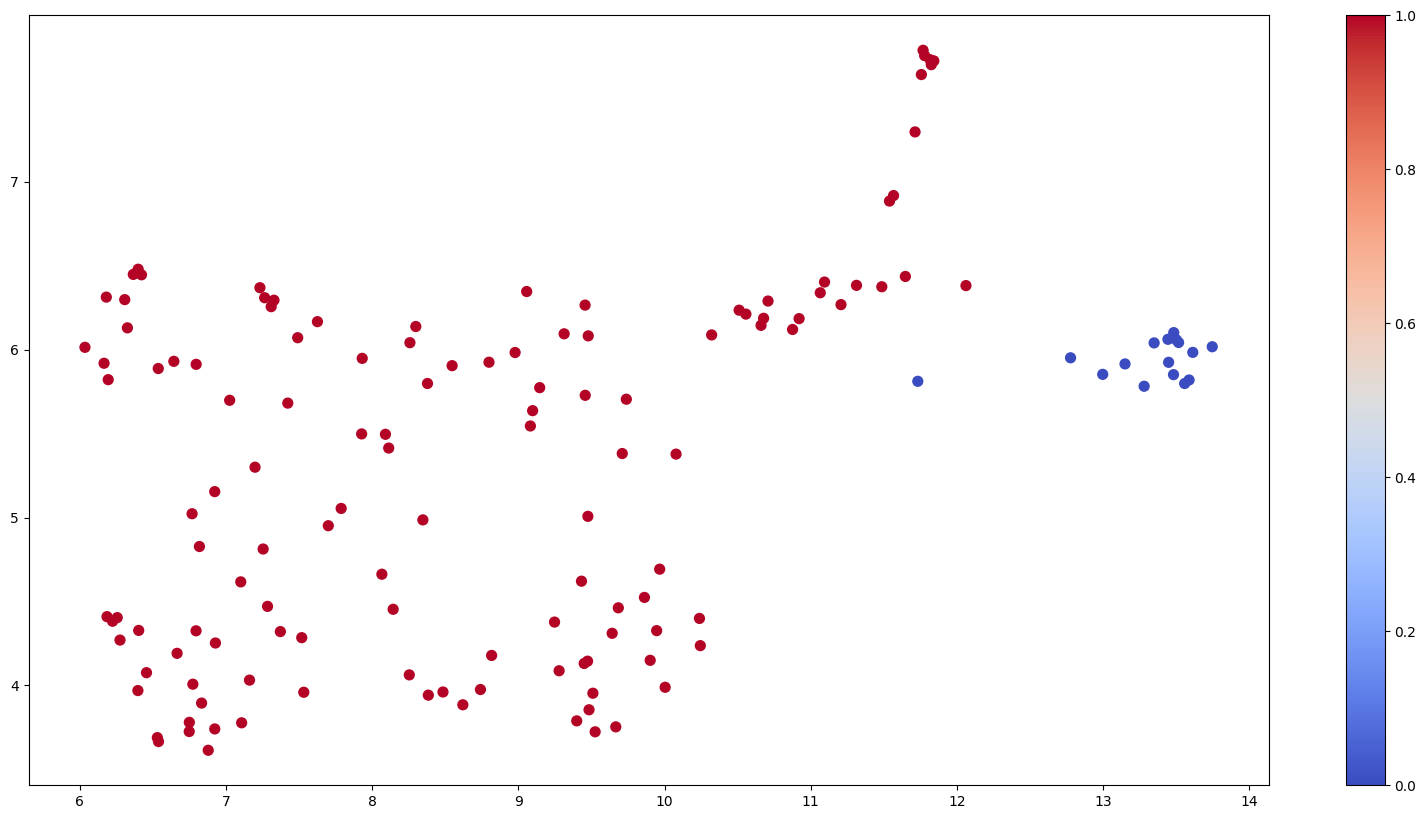

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='coolwarm',s=50)
plt.colorbar()

In [50]:
data['labels'] = cluster.labels_
data.head(10)

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,1
1,Town of Milford,Fresh Produce,1
2,LaPaz,larger variety,1
3,Galien mi,Fresh produce,1
4,Bremen,Good fresh produce,1
5,"Wakarusa, IN",N/a,1
6,"Wakarusa, IN",more fresh/healthy options,1
7,"North Liberty, IN","I don't shop at the Dollar General, but the lo...",1
8,Warsaw,Grocery Store other than Dollar General close ...,1
9,Wakarusa,More fresh food,1


In [56]:
data.drop(data.loc[data['labels']==0].index, inplace=True)

In [59]:
model_class, tokenizer_class, pretreined_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretreined_weights)

model = model_class.from_pretrained(pretreined_weights)

tokenized = data['Missing'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0             [101, 14161, 22287, 2243, 8950, 2078, 102]
1                                 [101, 4840, 3965, 102]
2                                 [101, 3469, 3528, 102]
3                                 [101, 4840, 3965, 102]
4                           [101, 2204, 4840, 3965, 102]
                             ...                        
136    [101, 2057, 2031, 2053, 2334, 13025, 3573, 101...
137    [101, 4840, 3965, 1010, 2204, 6240, 2533, 1010...
138    [101, 2632, 4305, 2030, 16269, 2544, 1997, 130...
139      [101, 15184, 1998, 2152, 3737, 4840, 3965, 102]
141            [101, 3029, 1013, 3688, 2006, 15475, 102]
Name: Missing, Length: 126, dtype: object

In [60]:
max_len = 0

for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i+[0]*(max_len-len(i)) for i in tokenized.values])

padded = np.array([list(x[:512]) for x in padded])

np.array(padded).shape

(126, 66)

In [62]:
attention_mask = np.where(padded != 0,1,0)
attention_mask.shape

(126, 66)

In [63]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask = attention_mask)

In [64]:
features = last_hidden_states[0][:,0,:].numpy()
features.shape

(126, 768)

In [65]:
umap_embeddings = umap.UMAP(n_neighbors=10,n_components=5,metric = 'cosine').fit_transform(features)
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric = 'euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [66]:
cluster.labels_

array([ 2, -1,  2, -1,  1, -1,  1,  0,  1, -1,  0, -1, -1,  0, -1, -1,  2,
        1,  2, -1, -1, -1, -1,  1,  0,  1, -1,  2, -1, -1, -1,  1,  1,  0,
       -1,  0, -1,  1,  0,  1, -1,  0,  0, -1,  0,  1,  0,  1, -1,  1, -1,
        0,  1, -1,  2, -1, -1,  1,  1,  2, -1, -1, -1,  2,  0, -1,  1, -1,
       -1, -1, -1,  2,  2,  0,  1,  1,  1,  1, -1, -1,  1,  0, -1, -1,  2,
        1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  2, -1, -1,  1,  1, -1,  1,
        2,  0,  0, -1, -1,  1, -1, -1,  0,  1,  2, -1,  2, -1, -1, -1,  1,
        1,  2,  0,  1, -1,  1, -1], dtype=int64)

In [67]:
# Prepare data to visualize
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(features)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



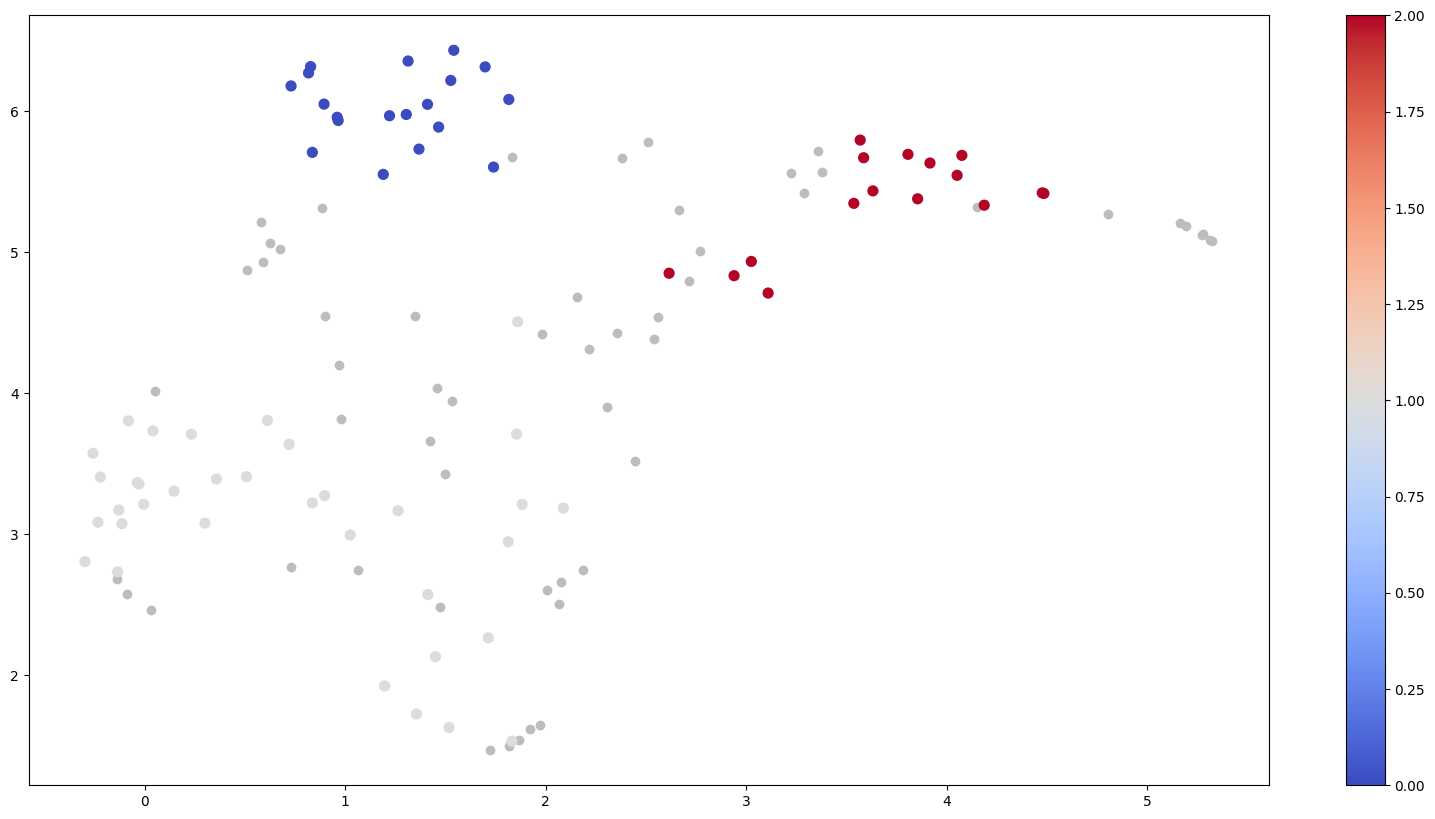

In [68]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='coolwarm',s=50)
plt.colorbar()

In [69]:
data['labels'] = cluster.labels_
data.head(10)

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,2
1,Town of Milford,Fresh Produce,-1
2,LaPaz,larger variety,2
3,Galien mi,Fresh produce,-1
4,Bremen,Good fresh produce,1
5,"Wakarusa, IN",N/a,-1
6,"Wakarusa, IN",more fresh/healthy options,1
7,"North Liberty, IN","I don't shop at the Dollar General, but the lo...",0
8,Warsaw,Grocery Store other than Dollar General close ...,1
9,Wakarusa,More fresh food,-1


In [74]:
data.loc[data['labels']==2]

,Town,Missing,labels
0,"South Bend, Indiana",knkmknkn,2
2,LaPaz,larger variety,2
16,Lakeville,fresh prodcue,2
18,North Liberty,Fresh Food,2
27,"Bremen, IN",Cashers,2
55,Rochester,price controlled healthy choices,2
60,North Judson,Decent Produce,2
64,"Knox, IN, unicorporated Starke County",affordable food,2
76,"Knox, Indiana",unsure,2
77,Plymouth,More variety,2


## Topic Modeling - Applying labels to each sentence

In [44]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components = n_components,
                                 metric='cosine',
                                 random_state=random_state).fit_transform(message_embeddings))
    
    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [45]:
def score_clusters(clusters, prob_threshold = 0.05):
    
    clusters_labels = clusters.labels_
    label_count = len(np.unique(clusters_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [46]:
def random_search(embeddings,space,num_evals):
    
    results = []
    
    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [47]:
space = {"n_neighbors" : range(12,16),
         "n_components": range(3,7),
         "min_cluster_size": range(2,16),
         "random_state": 42}

random_use = random_search(features, space, 100)

KeyboardInterrupt: 

In [ ]:
random_use.head(25)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
48,48,13,4,6,2,0.000000
28,28,12,3,5,2,0.000000
15,15,12,3,10,3,0.035211
35,35,15,5,9,3,0.042254
69,69,13,4,10,3,0.042254
86,86,12,3,13,3,0.042254
44,44,13,4,14,3,0.042254
7,7,13,4,9,3,0.042254
70,70,15,5,10,3,0.042254
10,10,13,4,9,3,0.042254


In [ ]:
from hyperopt import Trials, STATUS_OK, space_eval, fmin, tpe, hp

In [ ]:
def objective(params, embeddings, label_lower, label_upper):
     
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [ ]:

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [ ]:
hspace = { "n_neighbors": hp.choice('n_neighbors', range(3,16)),
           "n_components": hp.choice('n_components',range(3,16)),
           "min_cluster_size": hp.choice('min_cluster_size',range(2,16)),
           "random_state":42}

label_lower = 3
label_upper = 5
max_evals = 100

In [ ]:
best_params, best_clusters_use, trials_use = bayesian_search(features,
                                                             space=hspace,
                                                             label_lower=label_lower,
                                                             label_upper=label_upper,
                                                             max_evals=max_evals)

100%|██████████| 100/100 [01:10<00:00,  1.41trial/s, best loss: 0.0]              
best:
{'min_cluster_size': 3, 'n_components': 4, 'n_neighbors': 5, 'random_state': 42}
label count: 3


In [ ]:
def plot_best_clusters(best_clusters_use,embeddings,n_neighbors=15,min_dist=0.1):
    
        umap_reduce = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components=2,
                                 min_dist=min_dist,
                                 metric='cosine',
                                 random_state=42)
                           .fit_transform(embeddings)
                       )

        point_size = 100.0 / np.sqrt(embeddings.shape[0])

        result = pd.DataFrame(umap_reduce, columns=['x', 'y'])
        result['labels'] = best_clusters_use.labels_

        fig, ax = plt.subplots(figsize=(14, 8))
        noise = result[result.labels == -1]
        clustered = result[result.labels != -1]
        plt.scatter(noise.x, noise.y, color='lightgrey', s=point_size)
        plt.scatter(clustered.x, clustered.y, c=clustered.labels,
                    s=point_size, cmap='jet')
        plt.colorbar()
        plt.show()

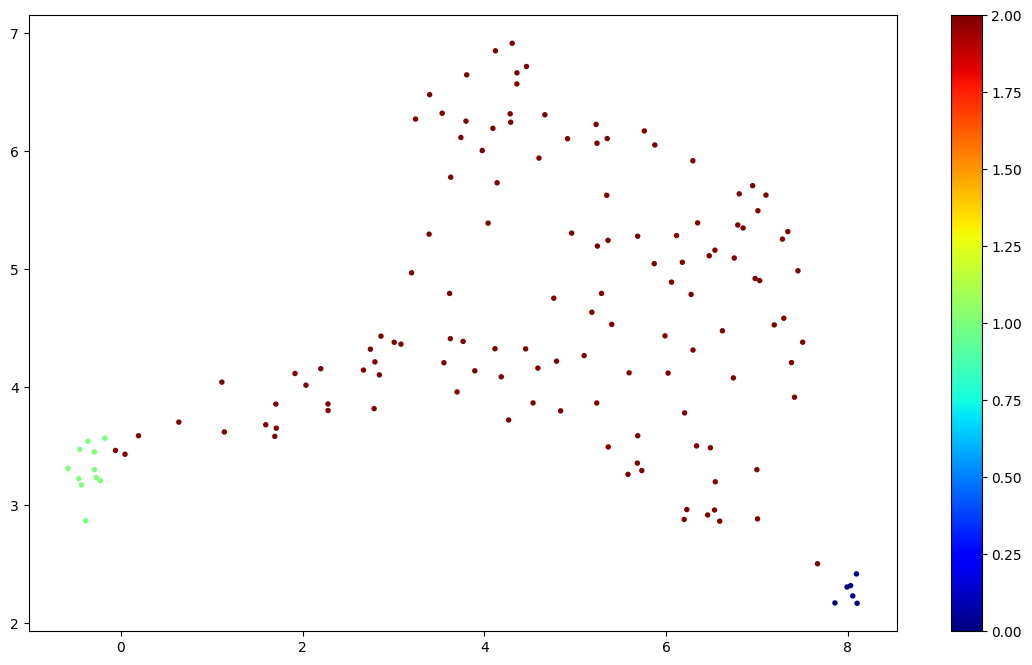

In [ ]:
plot_best_clusters(best_clusters_use,features)

In [ ]:
def get_group(df, category_col, category):
        """
        Return single category of documents with known labels
        Arguments:
            df: pandas dataframe of documents and associated ground truth
                labels
            category_col: str, name of column with document labels
            category: str, single document label of interest
        Returns:
            single_category: pandas dataframe with only documents from a
                             single category of interest
        """

        single_category = (df[df[category_col] == category]
                           .reset_index(drop=True)
                           )

        return single_category

In [ ]:
def most_common(lst, n_words):
        """
        Return most common n words in list of words
        Arguments:
            lst: list of words
            n_words: int, number of top words by frequency to return
        Returns:
            counter.most_common(n_words): a list of the n most common elements
                                          and their counts from the most
                                          common to the least
        """

        counter = collections.Counter(lst)

        return counter.most_common(n_words)



In [ ]:
import spacy
def extract_labels( category_docs):
        """
        Extract labels from documents in the same cluster by concatenating
        most common verbs, ojects, and nouns
        Argument:
            category_docs: list of documents, all from the same category or
                        clustering
        Returns:
            label: str, group label derived from concatentating most common
                   verb, object, and two most common nouns
        """

        verbs = []
        dobjs = []
        nouns = []
        adjs = []

        verb = ''
        dobj = ''
        noun1 = ''
        noun2 = ''

        try:
            nlp = spacy.load("en_core_web_sm")
        except OSError:
            print("Downloading language model for the spaCy dependency parser\n"
                  "(only required the first time this is run)\n")
            
            cli.download("en_core_web_sm")
            nlp = spacy.load("en_core_web_sm")

        for i in range(len(category_docs)):
            doc = nlp(category_docs[i])
            for token in doc:
                if token.is_stop is False:
                    if token.dep_ == 'ROOT':
                        verbs.append(token.text.lower())

                    elif token.dep_ == 'dobj':
                        dobjs.append(token.lemma_.lower())

                    elif token.pos_ == 'NOUN':
                        nouns.append(token.lemma_.lower())

                    elif token.pos_ == 'ADJ':
                        adjs.append(token.lemma_.lower())

        if len(verbs) > 0:
            verb = most_common(verbs, 1)[0][0]

        if len(dobjs) > 0:
            dobj = most_common(dobjs, 1)[0][0]

        if len(nouns) > 0:
            noun1 = most_common(nouns, 1)[0][0]

        if len(set(nouns)) > 1:
            noun2 = most_common(nouns, 2)[1][0]

        words = [verb, dobj]

        # ensures duplicated words aren't included
        for word in [noun1, noun2]:
            if word not in words:
                words.append(word)

        if '' in words:
            words.remove('')

        label = '_'.join(words)

        return label

In [ ]:
def apply_and_summarize_labels(best_clusters_use, df_data,category):
        """
        Assign groups to original documents and provide group counts
        Arguments:
            df_data: pandas dataframe of original documents of interest to
                     cluster
        Returns:
            df_summary: pandas dataframe with model cluster assignment, number
                        of documents in each cluster and derived labels
            labeled_docs: pandas dataframe with model cluster assignment and
                          associated dervied label applied to each document in
                          original corpus
        """

        # create a dataframe with cluster numbers applied to each doc
        category_col = 'label_use'
        df_clustered = df_data.copy()
        df_clustered[category_col] =  best_clusters_use.labels_

        numerical_labels = df_clustered[category_col].unique()

        label_dict = {}
        
        for label in numerical_labels:
            current_category = list(get_group(df_clustered,category_col,label)['What is missing in your current local store experience that you would like to see?'])
            print(extract_labels(current_category))
        
        df_summary = (df_clustered.groupby(category_col)['What is missing in your current local store experience that you would like to see?'].count()
                      .reset_index()
                      .rename(columns={'What is missing in your current local store experience that you would like to see?': 'count'})
                      .sort_values('count', ascending=False))
        
        df_summary['label'] = df_summary.apply(lambda x:
                                        label_dict[x[category_col]],
                                        axis=1)
        labeled_docs = pd.merge(df_clustered,
                        df_summary[[category_col, 'label']],
                        on=category_col,
                        how='left')

        return df_summary, labeled_docs
        